In [1]:
# Import packages
import pandas as pd 
#from pandas.plotting import scatter_matrix
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1)

In [2]:
def filter_articles_publications(articles, n_publications, p_top):
    """ 
    From a large DataFrame of posts from Medium-affiliated publications, 
    extract those from the most prolific publications.
    
    Arguments:
        articles = DataFrame containing post info
        n_publications = Number of publications with the most number of total 
            posts to filter based on
        p_top = Percentage threshold for most popular articles (evaluated based 
            on number of total claps) 
        titlekeyword = Word to look for in the title
        
    Outputs:
        articles_filtered = DataFrame of filtered articles, keeping only the 
            columns to be used in further analysis.
    """
    # Remove articles without an associated publication name, select only those 
    # with data explicitly in the name
    articles = articles[articles.publicationname.notnull()]
    articles = articles[articles["publicationname"].str.contains("Data")]
    
    # Construct list of unique publications, sort according to most prolific
    pub_count = articles.groupby(["publicationname"]).size().reset_index(
            name="counts")
    pub_count = pub_count.sort_values(["counts"],ascending=False)
    print(pub_count.head())
    
    print("Initial input: {} articles across {} publications".format(
            len(articles),len(pub_count)))
    
    # Filter articles to get only those from the top publications
    top_pubs = pub_count["publicationname"][0:n_publications+1].values.tolist()
    print(top_pubs)
    articles_filtered = articles[articles["publicationname"].isin(top_pubs)]
    
    # Remove duplicates identified based on identical post ID
    articles_filtered = articles_filtered.drop_duplicates(
            subset="postId", keep='first')
    
    # Filter articles to get only those that are most popular
    n_articles = int(np.ceil(p_top*len(articles_filtered)))
    articles_filtered = articles_filtered.sort_values(["totalClapCount"],
                                                    ascending=False)
    articles_filtered = articles_filtered.iloc[0:n_articles,:]
    
    # Pull out only the columns to be used in further analysis
    articles_filtered = articles_filtered[["postId",
                  "firstPublishedDatetime",
                  "imageCount",
                  "linksCount",
                  "tagsCount",
                  "text",
                  "title",
                  "wordCount",
                  "codeBlock",
                  "codeBlockCount",
                  "publicationname",
                  "totalClapCount",
                  "recommends",
                  "responsesCreatedCount"]]
    
    print(" ")
    print("Filter settings: Most popular {}% {} most prolific publications".format(
            p_top*100, n_publications))
    print("{} articles remaining".format(len(articles_filtered)))    
    
    return articles_filtered

In [3]:
def filter_articles_codeblocks(articles, n_codeblocks, p_top):
    """ 
    From a large DataFrame of posts from Medium-affiliated publications, 
    extract the most popular posts which also contain code.
    
    Arguments:
        articles = DataFrame containing post info
        n_codeblocks = Minimum number of codeblocks in post 
        p_top = Percentage threshold for most popular articles (evaluated based 
            on number of total claps) 
        titlekeyword = Word to look for in the title
        
    Outputs:
        articles_filtered = DataFrame of filtered articles, keeping only the 
            columns to be used in further analysis.
    """
    # Preliminary cleaning: remove articles with a missing publication name or
    # not in English
    articles = articles[articles.publicationname.notnull()]
    articles = articles[articles["language"] == "en"]
    
    print("Initial input: {} articles".format(len(articles)))
    
    # Remove articles without sufficient codeblocks
    articles_filtered = articles[articles["codeBlockCount"] >= n_codeblocks]
            
    # Filter articles to get only those that are most popular
    articles_filtered = articles_filtered.drop_duplicates(subset="postId", keep='first')
    n_articles = int(np.ceil(p_top*len(articles_filtered)))
    articles_filtered = articles_filtered.sort_values(["totalClapCount"],
                                                    ascending=False)
    articles_filtered = articles_filtered.iloc[0:n_articles,:]
    
    # Pull out only the columns to be used in further analysis
    articles_filtered = articles_filtered[["postId",
                  "firstPublishedDatetime",
                  "imageCount",
                  "linksCount",
                  "tagsCount",
                  "text",
                  "title",
                  "wordCount",
                  "codeBlock",
                  "codeBlockCount",
                  "publicationname",
                  "totalClapCount",
                  "recommends",
                  "url",
                  "responsesCreatedCount"]]
    
    print(" ")
    print("Filter settings: Most popular {}% with minimum {} codeblock".format(
            p_top*100, n_codeblocks))
    print("{} articles remaining".format(len(articles_filtered)))    
    
    return articles_filtered

In [4]:
# Import data
filedir_input = os.path.dirname(os.path.realpath('__file__'))
filename_input = os.path.join('../data/raw/Medium_AggregatedData.csv')
filename_input = os.path.abspath(os.path.realpath(filename_input))
articles = pd.read_csv(filename_input)
articles["firstPublishedDatetime"] = pd.to_datetime(
        articles["firstPublishedDatetime"])

In [5]:
n_articles = len(articles)
articles_g0 = articles[articles["totalClapCount"] > 0]
n_articles_g0 = len(articles_g0)
percent_g0 = (1 - (n_articles_g0/n_articles))*100

print("% of articles with clap count of 0: {}".format(percent_g0))

n_articles = len(articles)
articles_g10 = articles[articles["totalClapCount"] > 10]
n_articles_g10 = len(articles_g10)
percent_g10 = (1 - (n_articles_g10/n_articles))*100

print("% of articles with a clap count < 10: {}".format(percent_g10))

% of articles with clap count of 0: 28.869685274539748
% of articles with a clap count < 10: 52.39415259481288


In [6]:
percentiles = []
for i in np.arange(0,101,5):
    percentiles.append(np.percentile(articles["totalClapCount"], i))
for i in range(0,len(percentiles)):
    print("{}, {}".format(5*i,percentiles[i]))

0, 0.0
5, 0.0
10, 0.0
15, 0.0
20, 0.0
25, 0.0
30, 1.0
35, 1.0
40, 2.0
45, 4.0
50, 8.0
55, 14.0
60, 23.0
65, 40.0
70, 53.0
75, 72.0
80, 104.0
85, 158.0
90, 263.0
95, 575.0
100, 291706.0


In [7]:
claps_95 = articles[articles["totalClapCount"] > 575]
claps_95 = np.sum(claps_95["totalClapCount"].values)
print(claps_95)

all_claps = np.sum(articles["totalClapCount"].values)
print(all_claps)

print('5% of the articles have {0:.3f}% of the total claps.'.format((claps_95/all_claps)*100))

37910300
51711533
5% of the articles have 73.311% of the total claps.


In [8]:
# Filter articles
articles_filtered = filter_articles_codeblocks(articles,1,1)

Initial input: 127259 articles
 
Filter settings: Most popular 100% with minimum 1 codeblock
3175 articles remaining


In [9]:
# Duplicate the column containing a unique identifier (postId) so it can be 
# called directly later, then set it as the DF index
articles_filtered["postId2"] = articles_filtered["postId"]
articles_filtered.set_index("postId",inplace=True)

# Convert datetimeobjects to hour of post for later plotting
articles_timelist = []
articles_filtered_timelist = []
for i in range(0,len(articles)):
    articles_timelist.append(
            articles["firstPublishedDatetime"].iloc[i].time().hour)
for i in range(0,len(articles_filtered)):
    articles_filtered_timelist.append(
            articles_filtered["firstPublishedDatetime"].iloc[i].time().hour)

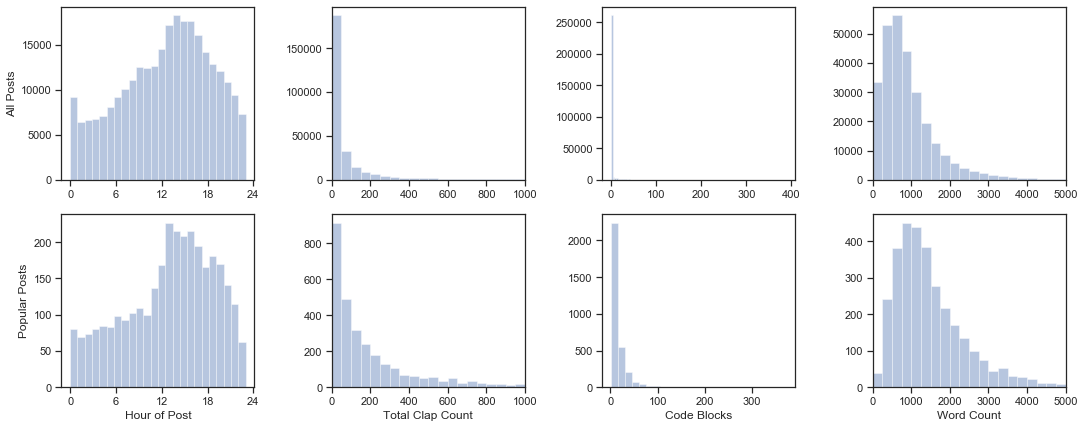

In [10]:
# Set up bins of predefined size for later histograms
bins_words = np.arange(0,5001,250)
bins_claps = np.arange(0,1001,50)


# Initial visualization: Difference in histograms of post characteristics 
# between all and popular posts
fig = plt.figure(figsize=(18,7))

ax1a = fig.add_subplot(2,4,1)
sns.distplot(articles_timelist,bins=24,kde=False)
plt.xticks(np.arange(0, 25, 6)) 
ax1a.set_ylabel('All Posts')

ax1b = fig.add_subplot(2,4,5)
sns.distplot(articles_filtered_timelist,bins=24,kde=False)
ax1b.set_xlabel('Hour of Post')
plt.xticks(np.arange(0, 25, 6)) 
ax1b.set_ylabel('Popular Posts')

ax2a = fig.add_subplot(2,4,2)
sns.distplot(articles["totalClapCount"],bins=bins_claps,kde=False)
ax2a.set_xlabel('')
ax2a.set_xlim(0,1000)

ax2b = fig.add_subplot(2,4,6)
sns.distplot(articles_filtered["totalClapCount"],bins=bins_claps,kde=False)
ax2b.set_xlabel('Total Clap Count')
ax2b.set_xlim(0,1000)

ax3a = fig.add_subplot(2,4,3)
sns.distplot(articles["codeBlockCount"],bins=100,kde=False)
ax3a.set_xlabel('')

ax3b = fig.add_subplot(2,4,7)
sns.distplot(articles_filtered["codeBlockCount"],bins=25,kde=False)
ax3b.set_xlabel('Code Blocks')

ax4a = fig.add_subplot(2,4,4)
sns.distplot(articles["wordCount"],bins=bins_words,kde=False)
ax4a.set_xlabel('')
ax4a.set_xlim(0,5000)

ax4b = fig.add_subplot(2,4,8)
sns.distplot(articles_filtered["wordCount"],bins=bins_words,kde=False)
ax4b.set_xlabel('Word Count')
ax4b.set_xlim(0,5000)

plt.subplots_adjust(wspace=0.4)